# Transfer learning

Various imports

In [153]:
# Silence Tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import List, Tuple

from tensorflow import keras
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

Configure the W&B run

In [139]:
batch_size = 32
epochs = 100

wandb.init(project="scRNA-seq-classification",
    config={"batch_size": batch_size, "epochs": epochs, "n_layers": 3, "n_nodes": [512, 256, 32], "dataset_name": ""})

wandb.log({"accuracy": 0.0, "loss": 0.0})

accuracy,▁
loss,▁
accuracy,0.0
loss,0.0


We start by reading expression matrices and labels for all male datasets

In [152]:
# Find all csv.gz files in the expr_matrices directory
filenames_expr = [f for f in os.listdir("expr_matrices") if f.endswith("M.csv.gz")]
filenames_clusters = [f for f in os.listdir("expr_matrices") if f.endswith("M_clusters.csv")]

print("Reading expression matrices...")
expr = [pd.read_csv(f"expr_matrices/{f}") for f in tqdm(filenames_expr)]

print([e.shape for e in expr])
# Now intersect the gene ids
common_genes = []
for item in expr:
    item.rename(columns={item.columns[0]: "gene_id"}, inplace = True)
    item.set_index("gene_id", inplace=True)
    if len(common_genes) == 0:
        common_genes = item.index
    else:
        common_genes = common_genes.intersection(item.index)

for i in range(len(expr)):
    expr[i] = expr[i].loc[common_genes]
    # Convert to Numpy array and transpose
    expr[i] = expr[i].values.T

print("Reading clusters...")
clusters = [pd.read_csv(f"expr_matrices/{f}") for f in tqdm(filenames_clusters)]

Reading expression matrices...


100%|██████████| 6/6 [00:03<00:00,  1.54it/s]


[(12204, 762), (12204, 1028), (12204, 810), (12204, 922), (12204, 2272), (12204, 485)]
Reading clusters...


100%|██████████| 6/6 [00:00<00:00, 1126.59it/s]


This defines our MLP

TODO: 

- hyperparameter tuning
- regularization / dropout

In [155]:
def build_model(n_clusters:int) -> keras.Model:
    """
    Build a 3-layer multi-class MLP classifier.
    
    param: n_clusters (int) - the number of clusters (possible classes)
    return: model (keras.Model) - the model    
    """

    # Now build our MLP
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(len(common_genes))))
    model.add(keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l1(0.001), name="dense_1"))
    model.add(keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l1(0.001), name="hidden_2"))
    model.add(keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l1(0.001), name="hidden_3"))
    # Output layer
    # Note the +1 to take into account the "other" class
    model.add(keras.layers.Dense(n_clusters + 1, activation="softmax", name="output"))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    # model.summary()

    return model


This function prepares the training data

TODO:

- augmentation through noise
- shuffled examples for "other" label

In [156]:
def prepare_training_data(expr: List, clusters: List, dataset_id: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare the training data for the MLP.

    param: expr (list) - the expression matrices
    param: clusters (list) - the list of cluster identities
    param: dataset_id (int) - the id of the dataset we are using as reference
    return: x_train (np.array) - the training data
    return: y_train (np.array) - the training labels
    """

    # We will use the expression matrices as the training data
    # The labels will be the cluster labels

    # We get the expression matrix and labels for the dataset we are using as reference...
    expr = expr[dataset_id]
    clusters = clusters[dataset_id]["Cluster"].values
    # ... and split into training and test data
    x_train, x_test, y_train, y_test = train_test_split(expr, clusters, test_size=0.1, random_state=42)

    # Scale the data with MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # One-hot encode labels
    y_train = keras.utils.to_categorical(y_train, num_classes=len(np.unique(clusters)) + 1)
    y_test = keras.utils.to_categorical(y_test, num_classes=len(np.unique(clusters)) + 1)

    return (x_train, y_train, x_test, y_test)

In [157]:
def get_augmented_samples(x_train: np.array, y_train: np.array, n: int = 1, perc_shuffle_genes: float = 0.01) -> Tuple[np.array, np.array]:
    """
    Creates augmented samples from the training data.

    param: x_train (np.array) - the training data
    param: y_train (np.array) - the training labels
    param: n (int) - the number of augmented samples to create. Default is 1.
    param: perc_shuffle_genes (float) - the percentage of genes to shuffle (per cell). Default is 0.01.
    return: x_train_aug, y_train_aug (np.array, np.array) - the augmented training data
    """

    # Get a list of cluster labels
    y_train_aug = np.random.choice(np.unique(np.argmax(y_train, axis=1)), size = n)

    # Shuffle the data on a per-cluster/per-gene basis

    # Split x_train by cluster
    x_by_cluster = [x_train[np.where(np.argmax(y_train, axis=1)==i)] for i in range(y_train.shape[1] - 1)]

    for x in x_by_cluster:
        genes = np.random.choice(x.shape[1], int(
            perc_shuffle_genes * x.shape[1]), replace=False)

        # Randomly swaps the values of the cells gene-wise
        for g in genes:
            x[:, g] = np.random.permutation(x[:, g])

    # Pick shuffled data corresponding to the cluster labels    
    x_train_aug = np.vstack([x_by_cluster[i][np.random.randint(0, x_by_cluster[i].shape[0]), :] for i in y_train_aug])

    # One-hot encode labels
    y_train_aug = keras.utils.to_categorical(y_train_aug, num_classes=y_train.shape[1])
    
    return (x_train_aug, y_train_aug)

In [158]:
ref_dataset = 0

dataset_name = filenames_expr[ref_dataset].split(".")[0]
print(f"Using dataset {dataset_name} as reference")

# Update in W&B
wandb.config.dataset_name = dataset_name

model  = build_model(len(clusters[ref_dataset]["Cluster"].unique()))
x_train, y_train, x_test, y_test = prepare_training_data(expr, clusters, ref_dataset)
x_train_aug, y_train_aug = get_augmented_samples(x_train, y_train, n=500, perc_shuffle_genes=0.01)

x_train = np.vstack([x_train, x_train_aug])
y_train = np.vstack([y_train, y_train_aug])

print(model.summary())

Using dataset Cheung2018M as reference
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               6248960   
                                                                 
 hidden_2 (Dense)            (None, 256)               131328    
                                                                 
 hidden_3 (Dense)            (None, 32)                8224      
                                                                 
 output (Dense)              (None, 6)                 198       
                                                                 
Total params: 6,388,710
Trainable params: 6,388,710
Non-trainable params: 0
_________________________________________________________________
None


Finally, we can train the model

In [159]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[WandbCallback()])

Epoch 1/100
37/37 [==============================] - 2s 25ms/step - loss: 26.7962 - accuracy: 0.5600 - val_loss: 8.5835 - val_accuracy: 0.5584 - _timestamp: 1657814645.0000 - _runtime: 188150.0000
Epoch 2/100
37/37 [==============================] - 1s 23ms/step - loss: 5.6954 - accuracy: 0.7449 - val_loss: 4.4495 - val_accuracy: 0.5455 - _timestamp: 1657814646.0000 - _runtime: 188151.0000
Epoch 3/100
37/37 [==============================] - 1s 23ms/step - loss: 3.4977 - accuracy: 0.8514 - val_loss: 3.3212 - val_accuracy: 0.7013 - _timestamp: 1657814647.0000 - _runtime: 188152.0000
Epoch 4/100
37/37 [==============================] - 1s 23ms/step - loss: 2.8115 - accuracy: 0.9198 - val_loss: 3.0083 - val_accuracy: 0.7143 - _timestamp: 1657814647.0000 - _runtime: 188152.0000
Epoch 5/100
37/37 [==============================] - 1s 23ms/step - loss: 2.5631 - accuracy: 0.9307 - val_loss: 2.6298 - val_accuracy: 0.8831 - _timestamp: 1657814648.0000 - _runtime: 188153.0000
Epoch 6/100
37/37 [

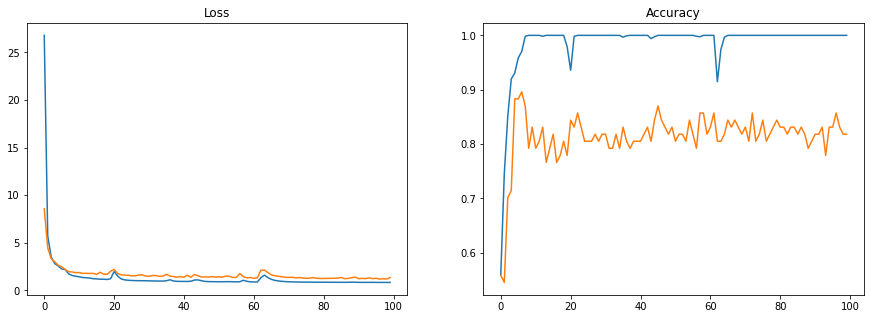

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history["loss"], label="train")
ax[0].plot(history.history["val_loss"], label="test")
ax[0].set_title("Loss")
ax[1].plot(history.history["accuracy"], label="train")
ax[1].plot(history.history["val_accuracy"], label="test")
ax[1].set_title("Accuracy")
plt.show()

In [163]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 1.3361 - accuracy: 0.8182


[1.3361262083053589, 0.8181818127632141]

In [33]:
wandb.finish()

accuracy,▁▅██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_accuracy,▁▆▇██▇▆▇▇▇▇▇▇▇▇▇█▇█▇▂▅▅▆▅▆▆▆▆▅▅▅▅▅▆▅▆▄▄▅
val_loss,▁▁▂▃▃▃▃▃▃▄▄▅▄▄▄▄▅▅▅▅▅▃▄▄▅▅▆▆▆▇▇▇▇▇▇█▆▄▄▄
accuracy,1.0
best_epoch,1
best_val_loss,1.40788
epoch,99
loss,0.00168
val_accuracy,0.48387
